In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import cv2
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PATH = os.getcwd()
PATH

'/home/leeping/Documents/Repositories/ML-CV-Facial-Keypoint-Detection'

## 1. Detect All Faces in Image

Use a pre-trained Haar Cascade frontal face detector to locate the faces in the image.

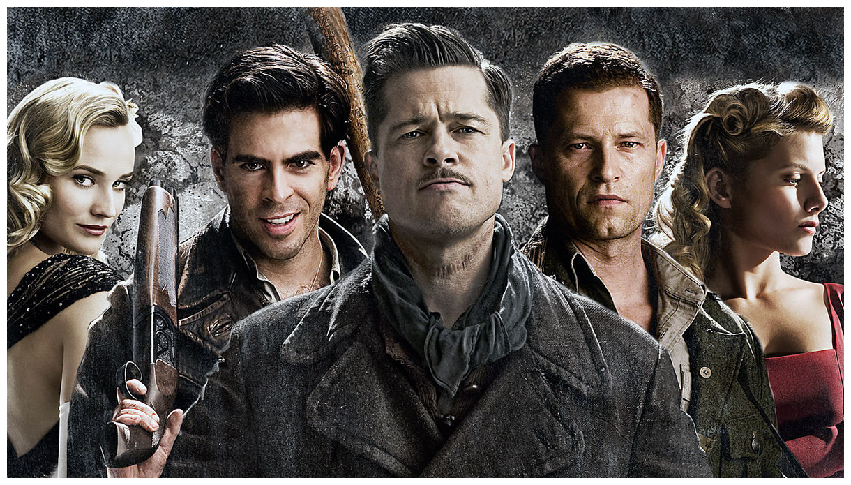

In [4]:
# load in color image for face detection
image = cv2.imread(PATH+'/images/basterds.jpg')

# convert from BGR to RGB (openCV reads in image as BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig_width = 15
fig_height = 10
fig_shape = [15,10]

fig = plt.figure(figsize=tuple(fig_shape))
plt.imshow(image)
plt.axis('off')
plt.show()

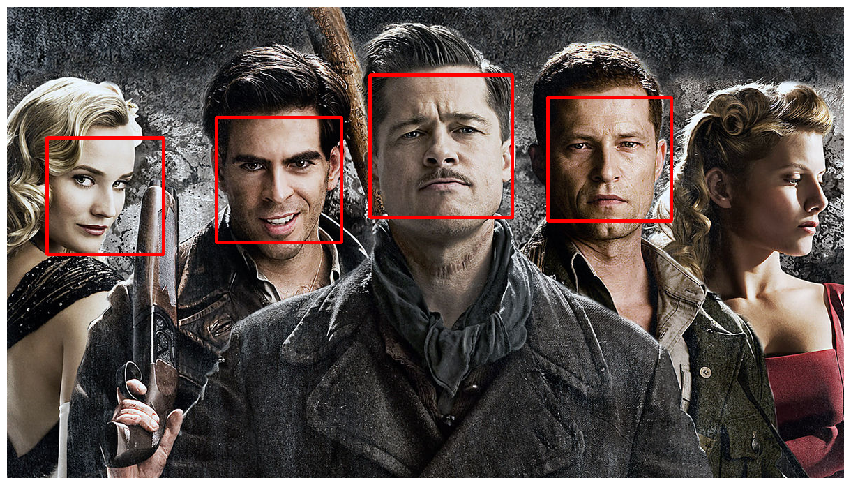

In [5]:
from src.detect_face import detect_face

# if the bounding boxes don't look right, try adjusting the value of scale_factor
face_vertices = detect_face(PATH+'/detector_architectures/haarcascade_frontalface_default.xml',
                   image, fig_shape, scale_factor=1.2, show=True)

## 2. Train CNN to Recognize Facial Keypoints

In [ ]:
# Download data and extract into path/data

# %%capture

# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [6]:
from src.preprocess import prepare_data

train_dataset, test_dataset = prepare_data(path_train_csv = PATH+'/data/training_frames_keypoints.csv',
                                          path_test_csv = PATH+'/data/test_frames_keypoints.csv',
                                          path_train_images = PATH+'/data/training/',
                                           path_test_images = PATH+'/data/test/')

Data preprocessed and transformed.
No. of training data:  3462
No. of test data:  770


In [7]:
# load training data in batches
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

# load test data in batches
batch_size = 64
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [8]:
from src.model import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

In [16]:
n_epochs = 50
use_GPU = True

In [17]:
from src.train import train


net, train_loss, valid_loss = train(n_epochs, 
                                   net, 
                                   train_loader, 
                                   test_loader,
                                   use_GPU)

Using GPU for training...
Epoch: 1/1, Batch: 27, Training Loss: 0.061 Validation Loss: 0.042
Epoch: 1/1, Batch: 54, Training Loss: 0.045 Validation Loss: 0.048
Finished Training


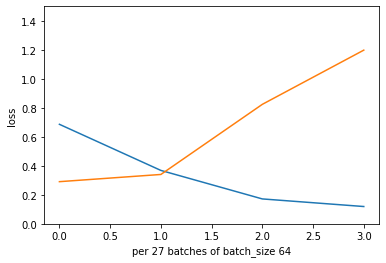

In [48]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('per 27 batches of batch_size 64')
plt.ylabel('loss')
plt.ylim(0, 1.5) # consistent scale
plt.show()

In [60]:
#torch.save(net.state_dict(), PATH + '/saved_models/naimish_net_1epoch.pt')

## 3. Plot Facial Keypoints on Image

In [9]:
net.load_state_dict(torch.load(PATH+'/saved_models/naimish_net_30epochs.pt'))

<All keys matched successfully>

In [10]:
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

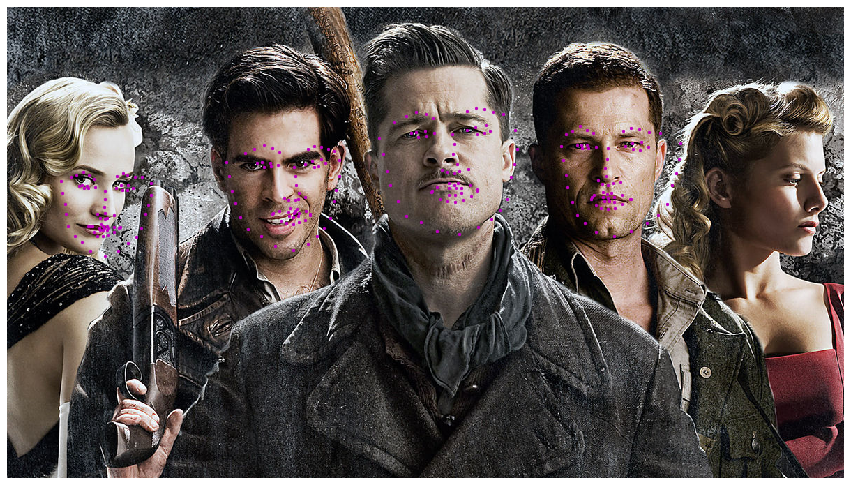

In [13]:
from src.draw import show_keypoints

# need padding as the haar cascade's bounding box is very close to face
# but training images are zoomed out further
keypoints = show_keypoints(image, 
                         face_vertices, 
                         net, 
                         use_GPU, 
                         fig_shape, 
                         pad=50)

## 4. Add Features to Faces

Image shape:  (106, 260, 4)
The alpha channel looks like this (black pixels = transparent): 


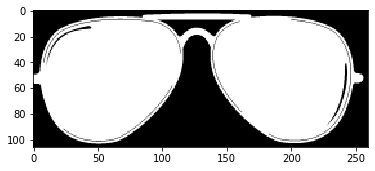

In [14]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
shades = cv2.imread('images/shades.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(shades)

# print out its dimensions
print('Image shape: ', shades.shape)

alpha_channel = shades[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

The indexes of the predicted keypoints are given in the following image. We can use these indexes to position accessories such as shades.

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

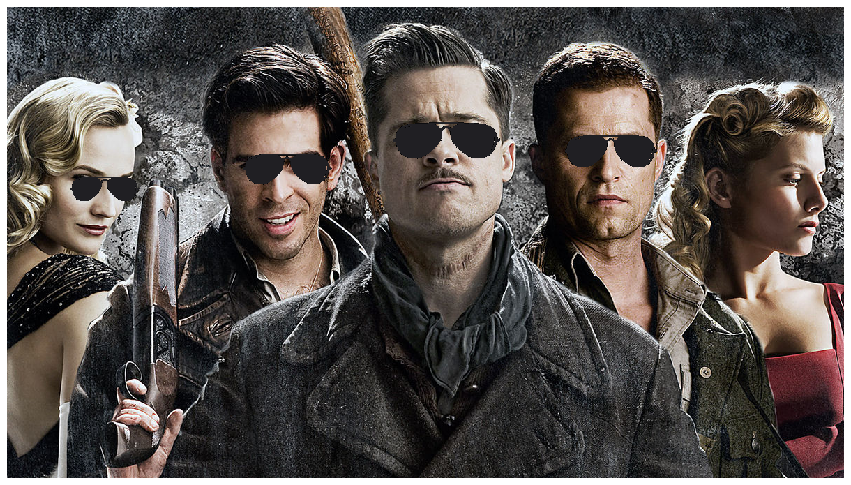

In [15]:
from src.draw import show_shades

show_shades(image, face_vertices, shades, keypoints, fig_shape)